In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Fixed import path
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tr1gg3rtrash/yoga-posture-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1


##Helper Function

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-02-18 11:14:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-18 11:14:24 (90.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [ ]:
# Walk through each directory
dataset = "/root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1"
walk_through_dir(dataset)

There are 47 directories and 1 images in '/root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1'.
There are 0 directories and 64 images in '/root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1/Virabhadrasana One'.
There are 0 directories and 81 images in '/root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1/Baddha Konasana'.
There are 0 directories and 56 images in '/root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1/Marjaryasana'.
There are 0 directories and 13 images in '/root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1/Ardha Navasana'.
There are 0 directories and 13 images in '/root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1/Supta Kapotasana'.
There are 0 directories and 73 images in '/root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1/Salamba Sarvangasana'.
There are 0 directories and 77 images in '/root/.cac

#Placing data into a Dataframe
The first column filepaths contains the file path location of each individual images. The second column labels, on the other hand, contains the class label of the corresponding image from the file path

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

,Filepath,Label
0,/root/.cache/kagglehub/datasets/tr1gg3rtrash/y...,Virabhadrasana One
1,/root/.cache/kagglehub/datasets/tr1gg3rtrash/y...,Virabhadrasana One
2,/root/.cache/kagglehub/datasets/tr1gg3rtrash/y...,Virabhadrasana One
3,/root/.cache/kagglehub/datasets/tr1gg3rtrash/y...,Virabhadrasana One
4,/root/.cache/kagglehub/datasets/tr1gg3rtrash/y...,Virabhadrasana One
...,...,...
4664,/root/.cache/kagglehub/datasets/tr1gg3rtrash/y...,Vrksasana
4665,/root/.cache/kagglehub/datasets/tr1gg3rtrash/y...,Vrksasana
4666,/root/.cache/kagglehub/datasets/tr1gg3rtrash/y...,Vrksasana
4667,/root/.cache/kagglehub/datasets/tr1gg3rtrash/y...,Vrksasana


#Visualizing images from the dataset

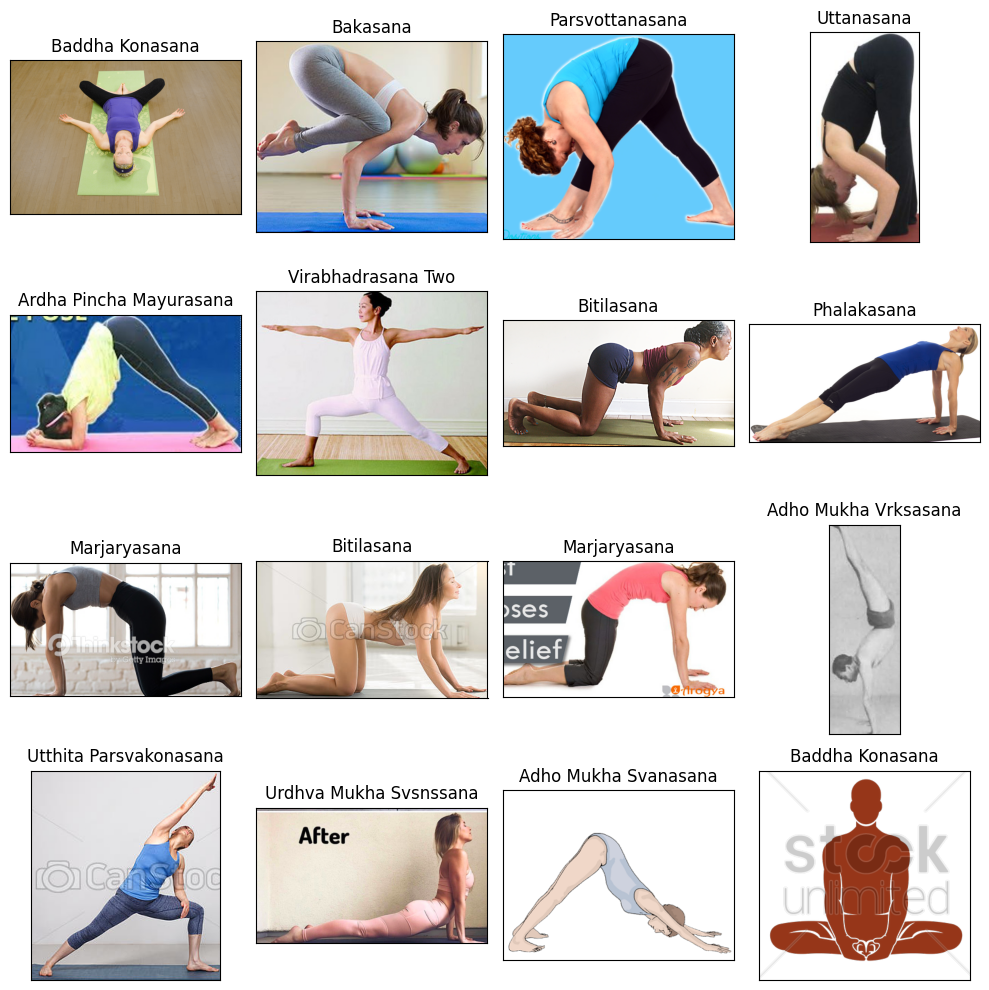

In [ ]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

#Computing Error

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

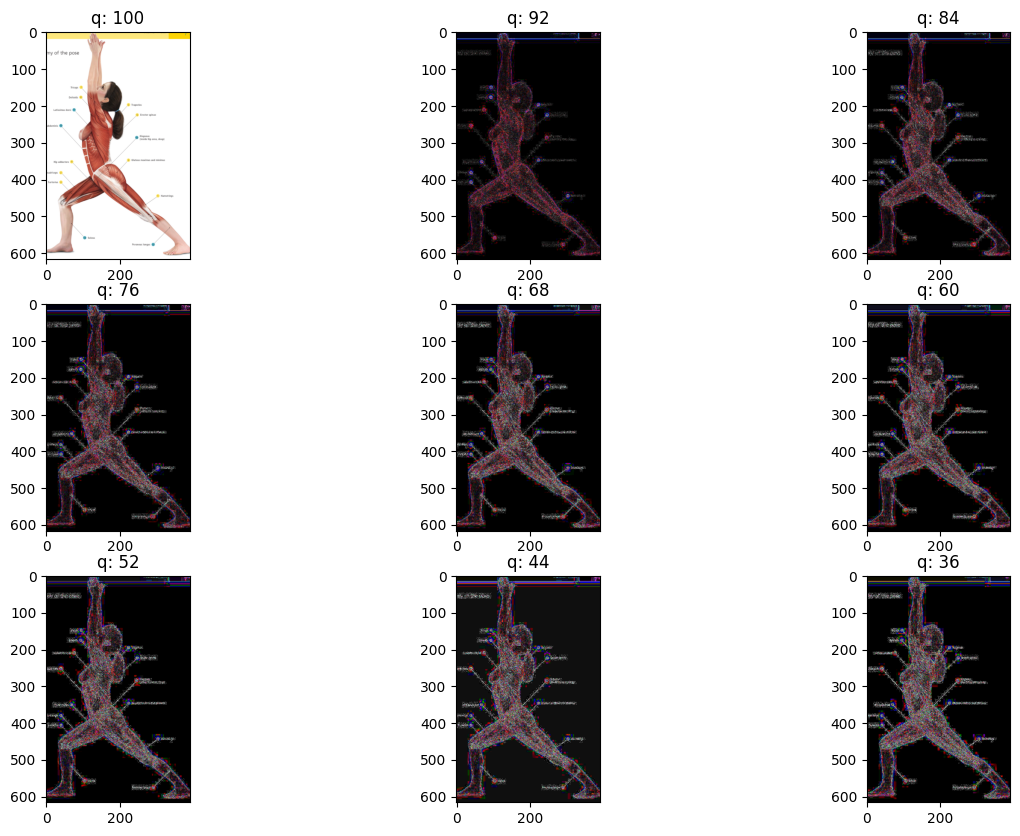

In [ ]:
# View random sample from the dataset
p = random_sample('/root/.cache/kagglehub/datasets/tr1gg3rtrash/yoga-posture-dataset/versions/1/Virabhadrasana One')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

#Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2988 validated image filenames belonging to 43 classes.
Found 747 validated image filenames belonging to 43 classes.
Found 934 validated image filenames belonging to 41 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")

#Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

Batch size : 32

Epochs : 100

Input Shape : (224, 224, 3)

Output layer : 43

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "yoga_classification_model_checkpoint.weights.h5"  # Added .weights.h5 extension
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

#Train the model

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(43, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/yoga_classification/20250218-113914


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
15/94 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.0440 - loss: 4.0122

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.0314 - loss: 3.9966 - val_accuracy: 0.0361 - val_loss: 3.8212
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.0254 - loss: 3.8795 - val_accuracy: 0.0469 - val_loss: 3.7489
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.0304 - loss: 3.8060 - val_accuracy: 0.0549 - val_loss: 3.6901
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.0452 - loss: 3.7472 - val_accuracy: 0.0629 - val_loss: 3.6428
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.0534 - loss: 3.6962 - val_accuracy: 0.0696 - val_loss: 3.5989
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.0659 - loss: 3.6252 - val_accuracy: 0.0736 - val_loss: 3.5584
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.0820 - loss: 3.5984 - val_accuracy: 0.0817 - val_loss: 3.5203
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.0777 - loss: 3.5482 - val_accuracy: 0.0977 - val_l

#Model Evaluation

The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

Precision(P):
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

P
=
T
P
/
(
T
P
+
F
P
)

Recall(R):
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.

R
=
T
P
/
(
T
P
+
F
N
)

F1 score(F1):
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.

F
1
=
2
∗
(
T
P
∗
F
P
)
/
(
T
P
+
F
P
)

In [ ]:
# When using a TensorFlow Dataset
results = model.evaluate(val_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.01113
Test Accuracy: 77.38%


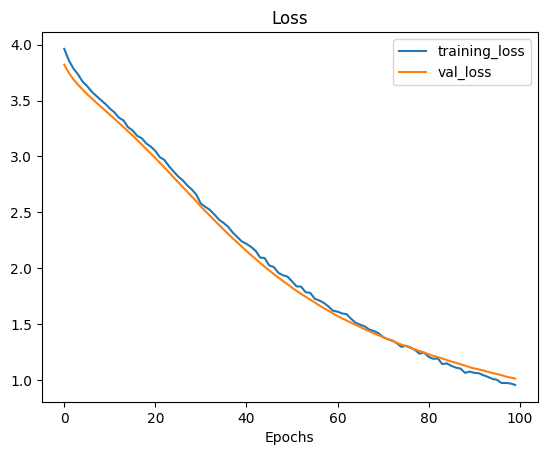

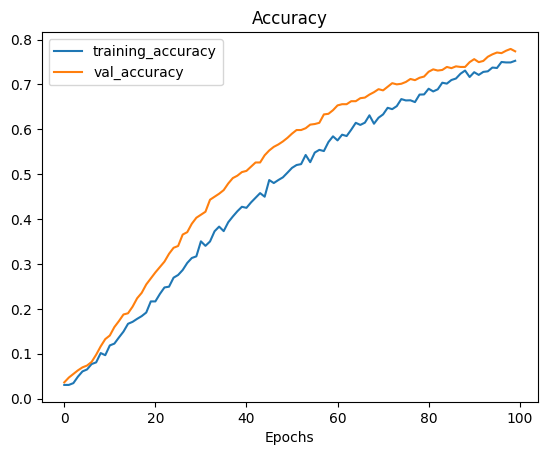

In [ ]:
plot_loss_curves(history)

#Prediction

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step
The first 5 predictions: ['Vasisthasana', 'Utkatasana', 'Bitilasana', 'Utthita Hasta Padangusthasana', 'Halasana']


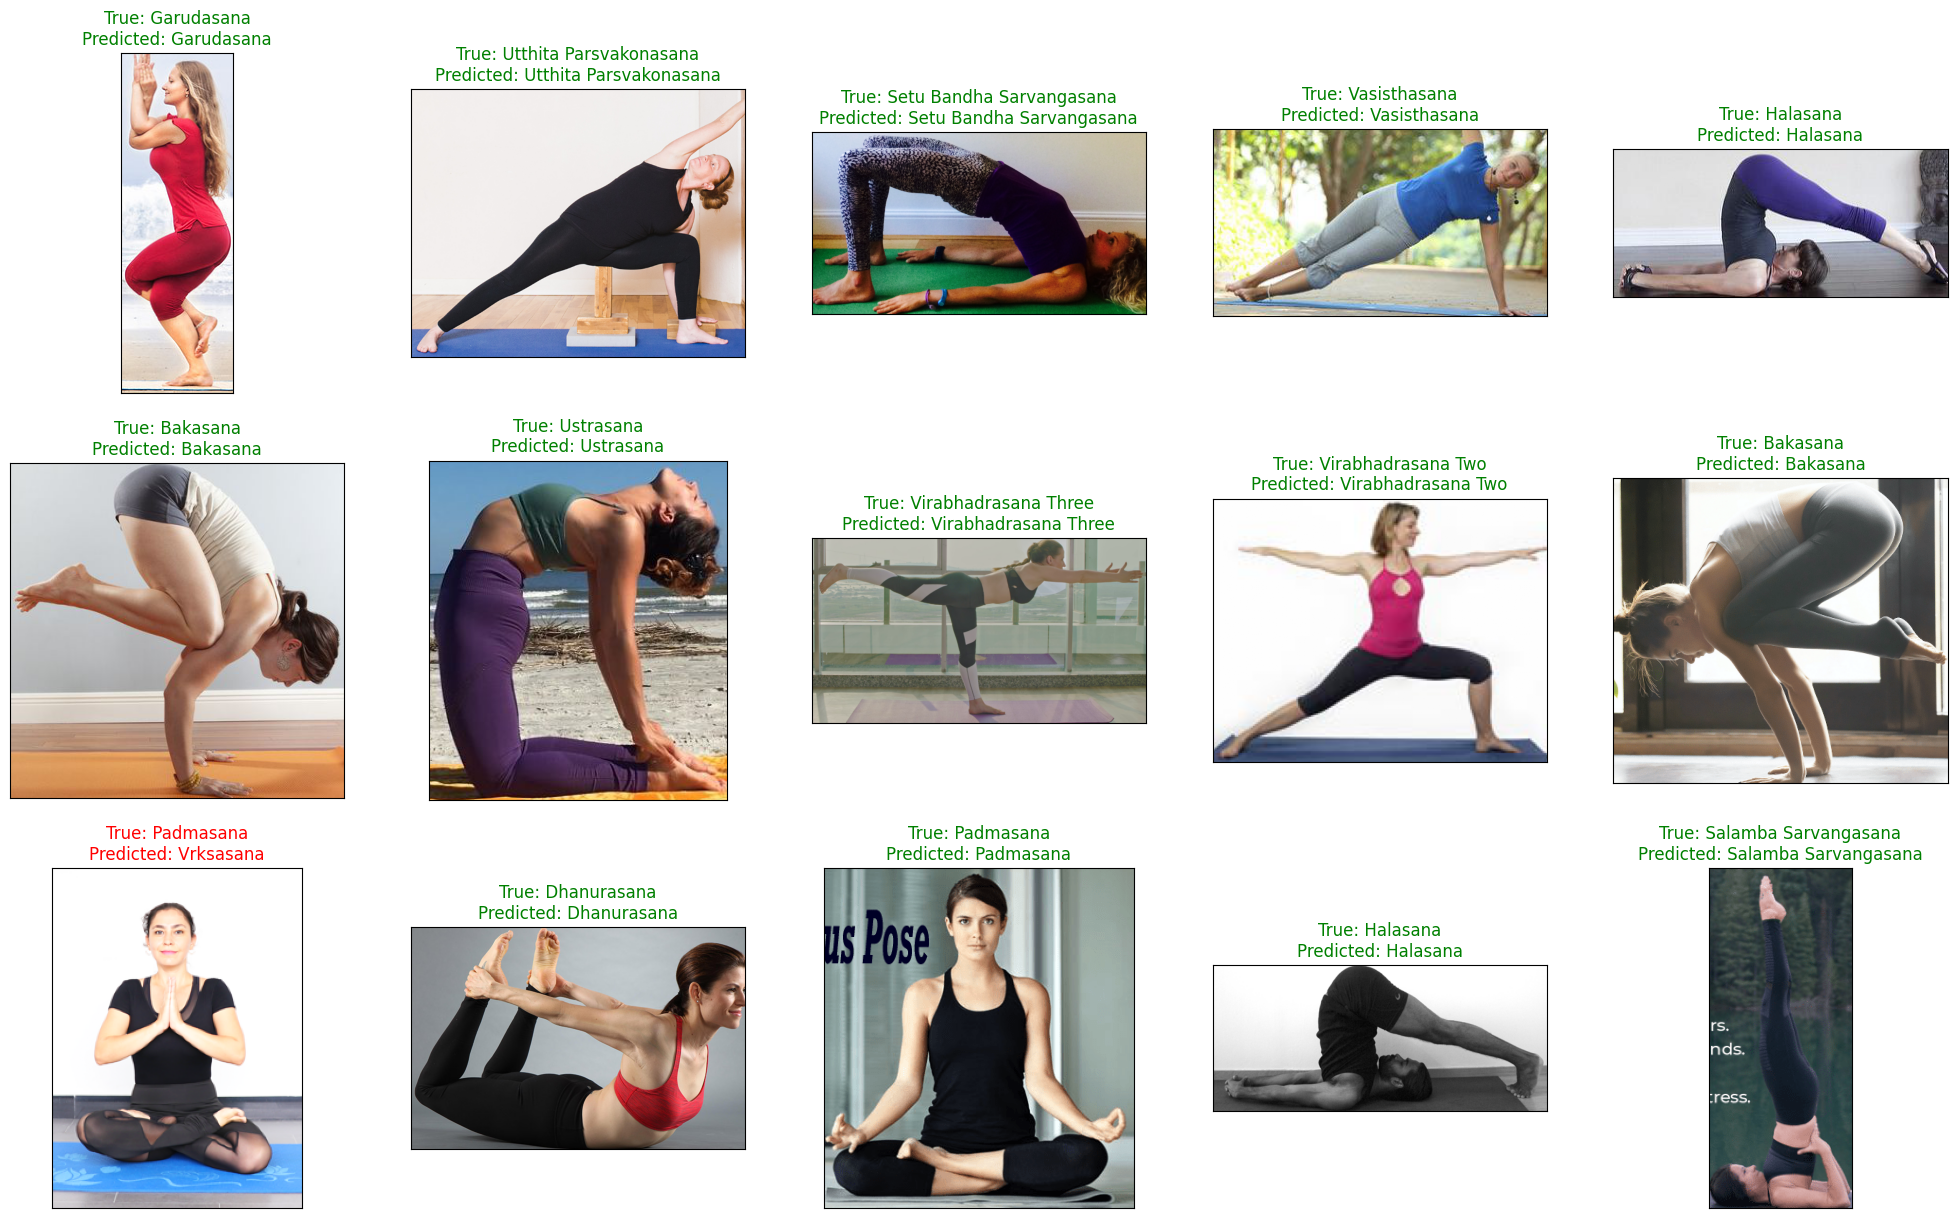

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

#Plotting Classification and Confusion matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.77      0.79      0.78        29
         Adho Mukha Vrksasana       0.68      0.68      0.68        19
                    Alanasana       0.00      0.00      0.00         4
                 Anjaneyasana       0.64      0.67      0.65        21
            Ardha Chandrasana       0.87      0.87      0.87        23
         Ardha Matsyendrasana       0.72      0.87      0.79        38
               Ardha Navasana       0.00      0.00      0.00         1
      Ardha Pincha Mayurasana       1.00      0.75      0.86        16
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.80      0.67      0.73        36
                     Bakasana       0.71      0.97      0.82        30
                     Balasana       0.72      0.75      0.74        28
                   Bitilasana       0.73      0.83      0.77        29
     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
Adho Mukha Svanasana,0.766667,0.793103,0.779661,29.000000
Adho Mukha Vrksasana,0.684211,0.684211,0.684211,19.000000
Alanasana,0.000000,0.000000,0.000000,4.000000
Anjaneyasana,0.636364,0.666667,0.651163,21.000000
Ardha Chandrasana,0.869565,0.869565,0.869565,23.000000
Ardha Matsyendrasana,0.717391,0.868421,0.785714,38.000000
Ardha Navasana,0.000000,0.000000,0.000000,1.000000
Ardha Pincha Mayurasana,1.000000,0.750000,0.857143,16.000000
Ashta Chandrasana,0.000000,0.000000,0.000000,1.000000
Baddha Konasana,0.800000,0.666667,0.727273,36.000000
